In [ ]:
import zipfile
import pandas as pd 

# Re-unzip the uploaded dataset after kernel reset
zip_path = "/Users/ashley/downloads/athletes.csv.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/Users/ashley/downloads/")

## Tool 1: LakeFS

## Define pipelines including: EDA; Dataset Split; Baseline ML Model

In [26]:
def simple_EDA():
    import seaborn as sns

    global data

    # Simple EDA

    # 1. Basic info and summary statistics
    print("Data shape:", data.shape)
    print("\nData types:\n", data.dtypes)
    print("\nMissing values:\n", data.isnull().sum())
    print("\nSummary statistics (numeric):\n", data.describe())

    # 2. Distribution of categorical features
    print("\nGender distribution:\n", data['gender'].value_counts())
    print("\nRegion distribution:\n", data['region'].value_counts().head())

    # 3. Visualizations
    import matplotlib.pyplot as plt

    # Histogram of age
    data['age'].hist(bins=20)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

    # Boxplot of weight by gender
    data.boxplot(column='weight', by='gender')
    plt.title('Weight by Gender')
    plt.suptitle('')
    plt.xlabel('Gender')
    plt.ylabel('Weight')
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

In [27]:
X_train, X_test, y_train, y_test = None, None, None, None
def calculate_total_lift_and_train_test_split():
    from sklearn.model_selection import train_test_split
    global X_train, X_test, y_train, y_test, data
    data["total_lift"] = data[["deadlift", "backsq", "snatch", "candj"]].sum(axis=1)
    data = data.dropna(subset=["total_lift"])

    features = ["age", "height", "weight", "deadlift", "backsq", "snatch", "candj"]
    target = "total_lift"
    data = data.dropna(subset=features)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        data[features], data[target], test_size=0.2, random_state=42
    )

In [28]:
def run_ml_pipeline():
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Ridge
    from sklearn.metrics import mean_squared_error, r2_score

    global X_train, X_test, y_train, y_test, data

    # Example ML pipeline: Standardize features, then fit Ridge regression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])

    # Fit pipeline on training data
    pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test MSE: {mse:.2f}")
    print(f"Test R^2: {r2:.3f}")

# Create 2 versions of data

### First version of data -v1

To use LakeFS as our data versioning tool, I create a repo called mlopsa1. Then, I manually upload the unzipped athletes.csv to main branch as our v1 data and commit.

In [21]:
data = pd.read_csv("lakefs://mlopsa1/main/athletes.csv")
data.head(5)

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


### Second version of data - v2

Then we work on the dataset v2




In [22]:
import numpy as np

# Remove not relevant columns
data = data.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                               'train','background','experience','schedule','howlong', \
                               'deadlift','candj','snatch','backsq','experience',\
                               'background','schedule','howlong'])
data = data.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',\
                              'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers

data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]

data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female') \
             & (data['deadlift'] <= 636))]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

# Clean Survey Data

decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background','experience','schedule','howlong','eat'])

In [23]:
data.to_csv("/Users/ashley/downloads/athletes.csv", index=False)

After saving the v2 data, we manually create a new branch in LakeFS. We call this branch v2. Then we upload the v2 data and commit.

Then we start to run ML pipelines. First, we run them on v1 data

In [ ]:
data = pd.read_csv("lakefs://mlopsa1/main/athletes.csv") # read v1 data

Data shape: (423006, 27)

Data types:
 athlete_id    float64
name           object
region         object
team           object
affiliate      object
gender         object
age           float64
height        float64
weight        float64
fran          float64
helen         float64
grace         float64
filthy50      float64
fgonebad      float64
run400        float64
run5k         float64
candj         float64
snatch        float64
deadlift      float64
backsq        float64
pullups       float64
eat            object
train          object
background     object
experience     object
schedule       object
howlong        object
dtype: object

Missing values:
 athlete_id         3
name           91896
region        171744
team          267846
affiliate     181090
gender         91896
age            91896
height        263137
weight        193116
fran          367580
helen         392727
grace         382261
filthy50      403647
fgonebad      393268
run400        400760
run5k         386909

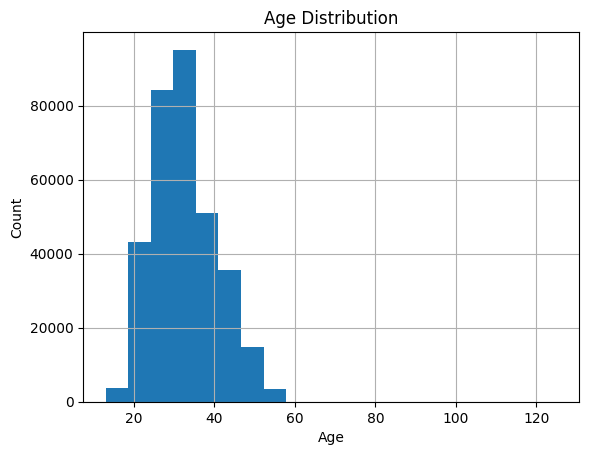

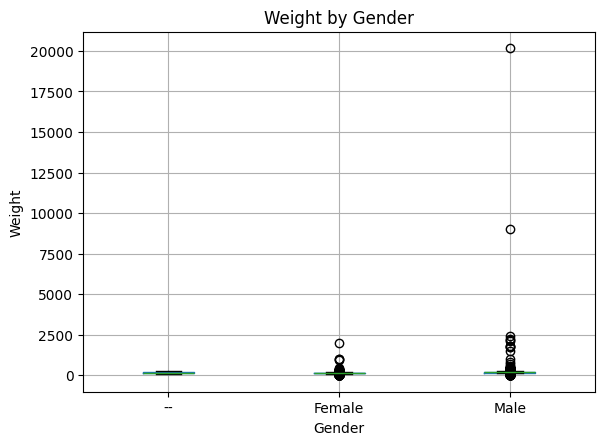

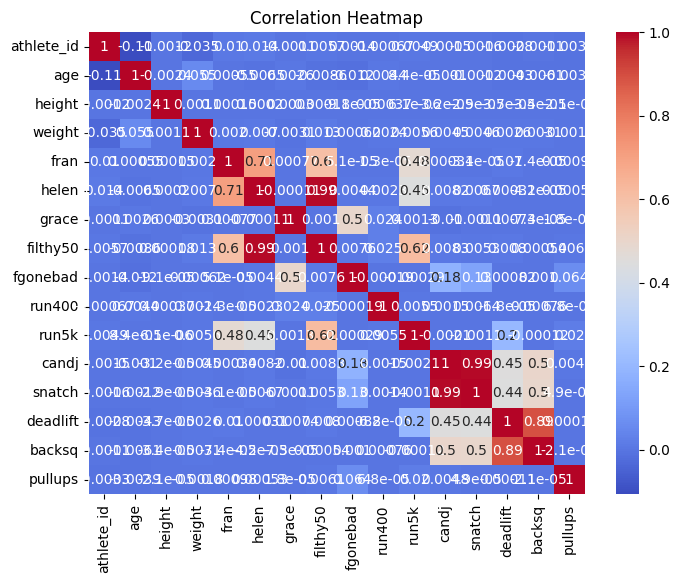

Test MSE: 1.36
Test R^2: 1.000


In [29]:
simple_EDA()
calculate_total_lift_and_train_test_split()
run_ml_pipeline()

Now switch to v2 branch, and them run the exactly same ML code.

In [30]:
data=pd.read_csv("lakefs://mlopsa1/v2/athletes.csv") # read v2 data

Data shape: (30029, 14)

Data types:
 region         object
gender         object
age           float64
height        float64
weight        float64
candj         float64
snatch        float64
deadlift      float64
backsq        float64
eat            object
background     object
experience     object
schedule       object
howlong        object
dtype: object

Missing values:
 region        0
gender        0
age           0
height        0
weight        0
candj         0
snatch        0
deadlift      0
backsq        0
eat           0
background    0
experience    0
schedule      0
howlong       0
dtype: int64

Summary statistics (numeric):
                 age        height        weight         candj        snatch  \
count  30029.000000  30029.000000  30029.000000  30029.000000  30029.000000   
mean      32.123847     68.871924    177.130607    205.418396    156.174198   
std        7.435425      3.774937     32.399828     58.687508     48.833572   
min       18.000000     52.000000    

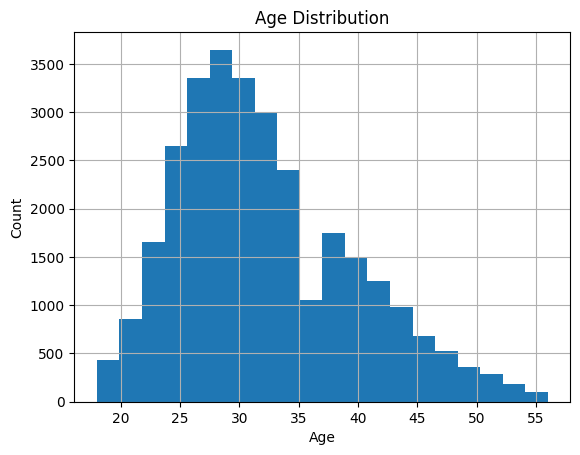

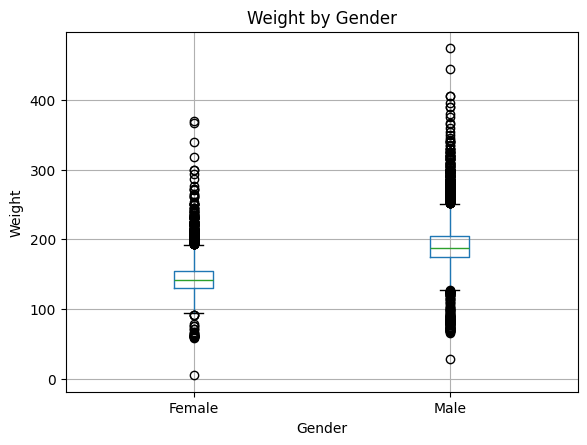

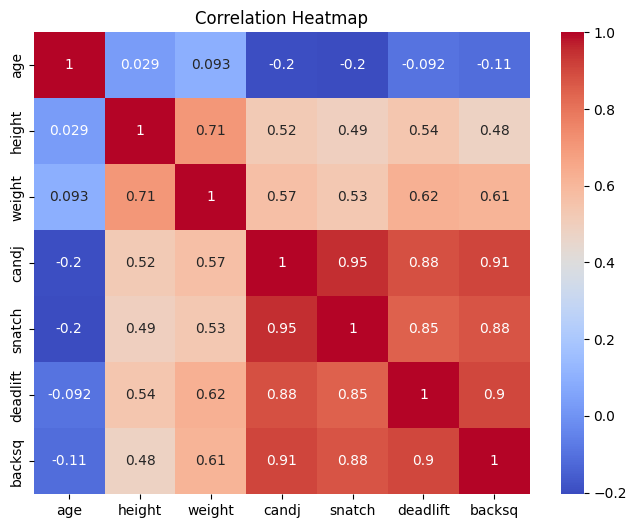

Test MSE: 0.00
Test R^2: 1.000


In [31]:
simple_EDA()
calculate_total_lift_and_train_test_split()
run_ml_pipeline()

### Task 12: Compare and comment on the accuracy/metrics of the models using v1 and v2

# Tool1: LakeFS - DP via TensorFlow

Codes below are run on Colab

In [ ]:
!pip install --upgrade git+https://github.com/tensorflow/privacy.git@master

In [1]:
data=pd.read_csv("lakefs://mlopsa1/v2/athletes.csv") # read v2 data

NameError: name 'pd' is not defined

In [ ]:
import numpy as np

# Remove not relevant columns
data = data.dropna(subset=['region','age','weight','height','howlong','gender','eat', \
                               'train','background','experience','schedule','howlong', \
                               'deadlift','candj','snatch','backsq','experience',\
                               'background','schedule','howlong'])
data = data.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',\
                              'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers

data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]

data = data[(data['deadlift'] > 0) & (data['deadlift'] <= 1105)|((data['gender'] == 'Female') \
             & (data['deadlift'] <= 636))]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

# Clean Survey Data

decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background','experience','schedule','howlong','eat'])

In [ ]:
from sklearn.model_selection import train_test_split
data["total_lift"] = data[["deadlift", "backsq", "snatch", "candj"]].sum(axis=1)
data = data.dropna(subset=["total_lift"])

features = ["age", "height", "weight", "deadlift", "backsq", "snatch", "candj"]
target = "total_lift"
data = data.dropna(subset=features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42
)

In [ ]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

import tensorflow as tf
import tensorflow_privacy as tfp

## Task 13: Use tensor flow privacy library with the dataset v2 and calculate the metrics for the new DP model.

### DP Model using Dataset v2

In [ ]:
batch_size = 64
delta      = 1e-5
epochs     = 60
n_samples = X_train.shape[0]


X_train = X_train.astype(np.float32)
X_test  = X_test .astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test .astype(np.float32)

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
      .shuffle(1000)
      .batch(batch_size, drop_remainder=True)
)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
              .batch(batch_size, drop_remainder=True)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1),
])


optimizer = tfp.DPKerasSGDOptimizer(
    l2_norm_clip=1,
    noise_multiplier=1.1,
    num_microbatches=batch_size,
    learning_rate=0.001
)
loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')])

model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
mse, mae = model.evaluate(test_ds, verbose=0)
print(f"Test MSE={mse:.4f}, MAE={mae:.4f}")


Epoch 1/60
375/375 - 4s - loss: 872768.3125 - mae: 897.4642 - val_loss: 656971.1250 - val_mae: 779.1205 - 4s/epoch - 10ms/step
Epoch 2/60
375/375 - 2s - loss: 447578.3750 - mae: 634.5515 - val_loss: 238575.1875 - val_mae: 464.8721 - 2s/epoch - 5ms/step
Epoch 3/60
375/375 - 2s - loss: 92376.7500 - mae: 255.6055 - val_loss: 4669.9019 - val_mae: 53.0548 - 2s/epoch - 5ms/step
Epoch 4/60
375/375 - 3s - loss: 2511.7339 - mae: 39.2225 - val_loss: 2196.8079 - val_mae: 36.8736 - 3s/epoch - 7ms/step
Epoch 5/60
375/375 - 2s - loss: 2073.7422 - mae: 36.0829 - val_loss: 2012.2563 - val_mae: 35.3967 - 2s/epoch - 5ms/step
Epoch 6/60
375/375 - 2s - loss: 1910.5963 - mae: 34.7209 - val_loss: 1866.7656 - val_mae: 34.1427 - 2s/epoch - 5ms/step
Epoch 7/60
375/375 - 2s - loss: 1769.4547 - mae: 33.4615 - val_loss: 1729.2531 - val_mae: 32.8879 - 2s/epoch - 5ms/step
Epoch 8/60
375/375 - 3s - loss: 1637.1595 - mae: 32.2033 - val_loss: 1590.8975 - val_mae: 31.5480 - 3s/epoch - 8ms/step
Epoch 9/60
375/375 - 2s -

## Task 14: Compute the DP epsilon
 using TensorFlow privacy compute_dp_sgd_privacy

In [ ]:
epsilon, optimal_order = tfp.compute_dp_sgd_privacy(
    n=n_samples,
    batch_size=batch_size,
    noise_multiplier=1.1,
    epochs=epochs,
    delta=delta
)
print(f"For δ={delta}, DP ε ≈ {epsilon:.2f}, optimal Rényi order α={optimal_order}")


For δ=1e-05, DP ε ≈ 1.99, optimal Rényi order α=10.0


### Non DP Model using Dataset v2

In [ ]:
model_non_dp = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1),
])

model_non_dp.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.001,
        clipnorm=1
    ),
    loss='mse',
    metrics=['mae']
)

model_non_dp.fit(train_ds, epochs=60, validation_data=test_ds, verbose=2)
mse_non_dp, mae_non_dp = model_non_dp.evaluate(test_ds, verbose=0)
print(f"Non-DP Test MSE={mse_non_dp:.4f}, MAE={mae_non_dp:.4f}")


Epoch 1/60
375/375 - 1s - loss: 999008.6250 - mae: 960.1439 - val_loss: 672368.5000 - val_mae: 791.0054 - 1s/epoch - 3ms/step
Epoch 2/60
375/375 - 1s - loss: 334264.6250 - mae: 528.5135 - val_loss: 38788.7266 - val_mae: 185.7262 - 673ms/epoch - 2ms/step
Epoch 3/60
375/375 - 1s - loss: 3402.6956 - mae: 33.6730 - val_loss: 227.1381 - val_mae: 11.1794 - 748ms/epoch - 2ms/step
Epoch 4/60
375/375 - 1s - loss: 105.9822 - mae: 7.5148 - val_loss: 48.7916 - val_mae: 4.9671 - 551ms/epoch - 1ms/step
Epoch 5/60
375/375 - 1s - loss: 35.3749 - mae: 4.3336 - val_loss: 30.3537 - val_mae: 3.7026 - 563ms/epoch - 2ms/step
Epoch 6/60
375/375 - 1s - loss: 26.5098 - mae: 3.6995 - val_loss: 26.2835 - val_mae: 3.5989 - 545ms/epoch - 1ms/step
Epoch 7/60
375/375 - 1s - loss: 22.0246 - mae: 3.3643 - val_loss: 22.7190 - val_mae: 3.3334 - 569ms/epoch - 2ms/step
Epoch 8/60
375/375 - 1s - loss: 19.3423 - mae: 3.1309 - val_loss: 22.6872 - val_mae: 3.1503 - 550ms/epoch - 1ms/step
Epoch 9/60
375/375 - 1s - loss: 17.149

Conclusion: